<a href="https://colab.research.google.com/github/gifale95/NED/blob/main/tutorials/ned_eeg_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Encoding Dataset | In silico EEG Data Tutorial

In this tutorial you will familiarize with the [Neural Encoding Dataset (NED)][ned]: trained encoding models of fMRI and EEG responses to images of multiple subjects. Through the [`NED` toolbox][github], you will use these trained encoding models to generate EEG responses to images.

The Neural Encoding Dataset also comes with pre-generated in silico fMRI and EEG responses for ~150,000 naturalistic images from the [ImageNet 2012 Challenge][imagenet] ([*Russakovsky et al., 2015*][russakovsky]), the [THINGS Database][things] ([*Hebart et al., 2019*][hebart]), and the [Natural Scenes Dataset][nsd] ([*Allen et al., 2022*][allen]), which you can use for research purposes. Here you will load and visualize these in silico EEG responses.

For more information on NED refer to the [data manual][data_manual]. The code used to create NED, along with its utility functions, is available on [GitHub][github].

You can run this tutorial either on [Colab][colab], or on [Jupyter Notebook][jupyter]. If you experience problems with the code, please get in touch with Ale (alessandro.gifford@gmail.com).

If you use the code and/or data from this tutorial, please cite:

> *Gifford AT, Cichy RM. 2024. The Neural Encoding Dataset. In preparation. https://github.com/gifale95/NED*

[ned]: https://www.alegifford.com/projects/ned/
[nsd]: https://naturalscenesdataset.org/
[allen]: https://doi.org/10.1038/s41593-021-00962-x
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://doi.org/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://doi.org/10.1371/journal.pone.0223792
[data_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit?usp=drive_link
[github]: https://github.com/gifale95/NED
[colab]: https://colab.research.google.com/drive/10NSRBrJ390vuaPyRWq5fDBIA4NNAUlTk?usp=sharing
[jupyter]: https://github.com/gifale95/NED/blob/main/tutorials/ned_eeg_tutorial.ipynb

# 0 | Configuration

Note that in sections `0.1 Install and import the necessary Python libraries` and `0.2 Access NED` you will have to run different code cells based on whether you are running the tutorial on Colab or on Jupyter Notebook. An `if statement` will take care of this. You only need to select `'colab'` or `'jupyter_notebook'` for the `platform` variable below.

In [1]:
platform = "colab" # @param ["colab", "jupyter_notebook"] {allow-input: true}

## 0.1 | Install and import the necessary Python libraries

### 0.1.1 | Install libraries, Google Colab

If you are running the tutorial on Google Colab, you just need to install the [NED toolbox][ned_git].

[ned_git]: https://github.com/gifale95/NED

In [2]:
!pip install -U git+https://github.com/gifale95/NED.git

  Cloning https://github.com/gifale95/NED.git to /tmp/pip-req-build-eun2sxiz
  Running command git clone --filter=blob:none --quiet https://github.com/gifale95/NED.git /tmp/pip-req-build-eun2sxiz
  Resolved https://github.com/gifale95/NED.git to commit 25b68306b5d270091ccc97739acd92e5f7f5c713
  Preparing metadata (setup.py) ... done
  Created wheel for NED: filename=NED-0.2.0-py3-none-any.whl size=46806 sha256=652206c2f04d701053ef79a710cff5fb0b163761a5d868f80134a3227cc2af9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_uka_6r/wheels/85/83/46/b8111e13e7857a1263e10d2a531fdedba00dc665a1d660c955
Successfully built NED


### 0.1.2 | Install libraries, Jupyter Notebook

If you are running the tutorial on Jupyter Notebook, you need to install the following libraries before running the tutorial:

[h5py][h5py], [jupyter][jupyter], [matplotlib][matplotlib], [ned][ned_git], [nibabel][nibabel], [numpy][numpy], [pillow][pil], [scikit-learn][sklearn], [torchvision][torchvision], [tqdm][tqdm].

[h5py]: https://docs.h5py.org/en/stable/
[jupyter]: https://jupyter.org/
[matplotlib]: https://matplotlib.org/stable/index.html
[ned_git]: https://github.com/gifale95/NED
[nibabel]: https://nipy.org/nibabel/
[numpy]: https://numpy.org/
[pil]: https://pypi.org/project/pillow/
[sklearn]: https://scikit-learn.org/stable/
[torchvision]: https://pytorch.org/vision/stable/index.html
[tqdm]: https://tqdm.github.io/

### 0.1.3 | Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [3]:
import h5py
import matplotlib
from matplotlib import pyplot as plt
from ned.ned import NED
import numpy as np
import os
from PIL import Image
from sklearn.svm import SVC
import torchvision
from torchvision import transforms as trn
from tqdm import tqdm

## 0.2 | Access NED

### 0.2.1 | Access NED on Google Colab

If you are running the tutorial on Google Colab you can use NED from the Google Drive public folder called [`neural_encoding_dataset`][ned]. Before running the tutorial code you need to right-click on this folder, and select `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can read the content after mounting using `drive.mount()`. Finally, edit the `ned_dir` variable below with the path on your Drive to the `neural_encoding_dataset` shortcut folder.

<font color='red'><b>NOTE:</b></font> **You need to manually create the data shortcut yourself, as the code cell below won't do this for you.**

[ned]: https://forms.gle/ZKxEcjBmdYL6zdrg9

In [4]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    ned_dir = '/content/drive/MyDrive/neural_encoding_dataset' #@param {type:"string"}

Mounted at /content/drive/


### 0.2.2 | Access NED on Jupyter Notebook

If you are running the tutorial on Jupyter Notebook you first need to download NED from the public Google Drive folder [`neural_encoding_dataset`][data], and then edit the `ned_dir` variable below with the path to the downloaded and unzipped data folder.

Note that the `neural_encoding_dataset` folder contains several hundred GBs of data, and thus the download might take a while. However, based on your needs you might only choose to download a part of the dataset. [NED's data manual][ned_manual] provides a detailed description of NED's content, which will help you in this choice.

We recommend downloading the dataset directly from Google Drive via terminal using [Rclone][rclone]. [Here][guide] is a step-by-step guide for how to install and use Rclone to move files to and from your Google Drive. Before downloading NED via terminal you need to add a shortcut of the `neural_encoding_dataset` folder to your Google Drive. You can do this by right-clicking on the `neural_encoding_dataset` folder, and selecting `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can download its content.

[data]: https://forms.gle/ZKxEcjBmdYL6zdrg9
[ned_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit#heading=h.n2idexbb49xj
[rclone]: https://rclone.org/
[guide]: https://noisyneuron.github.io/nyu-hpc/transfer.html

In [ ]:
if platform == 'jupyter_notebook':
    ned_dir = '../neural_encoding_dataset'

# 1 | Initialize NED

## 1.1 | Create the NED object

To use the `NED` toolbox, you first need to create a NED object, using the directory to the Neural Encoding Dataset.

In [5]:
ned_object = NED(ned_dir)

## 1.2 | Browse the available encoding models

The Neural Encoding Dataset contains several encoding models of neural responses, which are taxonomized based on _attributes_:
* **modality:** the neural data modality on which the encoding model was trained.
* **train_dataset:** the neural dataset on which the encoding model was trained.
* **model:** the type of encoding model used.
* **subject:** independent subjects on which encoding models were trained (a separate encoding model is trained for each subject).
* **roi:** independent Regions of Interest (ROIs) on which encoding models were trained (a separate encoding model is trained for each ROI). This only applies to fMRI neural data modality.

Here you will print what EEG encoding models are available for each attribute. For more information on the different models, see [NED's data manual][data_manual].

[data_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit?usp=drive_link

### 1.2.1 | Neural acquisition modalities

Print the neural data modalities for which there are encoding models in NED.

In [6]:
"""
Return the neural data modalities available in NED.

Returns
-------
modalities : list of str
    List of neural data modalities available in NED.
"""

modalities = ned_object.which_modalities()
print('Available neural data acquisition modalities:')
print(modalities)

Available neural data acquisition modalities:
['fmri', 'eeg']


### 1.2.2 | Neural datasets

For a given neural data modality, print the available neural datasets on which NED's encoding models were trained.

In [7]:
"""
For a given neural data modality, return the available datasets on which
the NED encoding models are trained.

Parameters
-------
modality : str
    Neural data modality.

Returns
-------
train_datasets : list of str
    List of neural datasets on which the NED encoding models are
    trained.
"""

modality = "eeg" # @param ["eeg"] {allow-input: true}
train_datasets = ned_object.which_train_datasets(modality)
print('Available datasets:')
print(train_datasets)

Available datasets:
['things_eeg_2']


### 1.2.3 | Encoding model types

For a given neural data modality and training dataset, print the encoding model types available in NED.

In [8]:
"""
For a given neural data modality and training dataset, return the
encoding model types available in NED.

Parameters
-------
modality : str
    Neural data modality.
train_dataset : str
    Neural dataset on which the NED encoding models are trained.

Returns
-------
models : list of str
    List of NED encoding models trained on a given neural data modality
    and neural dataset.
"""

modality = "eeg" # @param ["eeg"] {allow-input: true}
train_dataset = "things_eeg_2" # @param ["things_eeg_2"] {allow-input: true}
models = ned_object.which_models(modality, train_dataset)
print('Available models:')
print(models)

Available models:
['vit_b_32']


### 1.2.4 | Subjects

For a given neural data modality and training dataset, print the subjects for which there are trained encoding models.

In [9]:
"""
For a given neural data modality and training dataset, return the
available subjects on which encoding models are trained.

Parameters
-------
modality : str
    Neural data modality.
train_dataset : str
    Neural dataset on which the NED encoding models are trained.

Returns
-------
subjects : list of int
    List of available subjects for a given data modality and training
    dataset.
"""

modality = "eeg" # @param ["eeg"] {allow-input: true}
train_dataset = "things_eeg_2" # @param ["things_eeg_2"] {allow-input: true}
subjects = ned_object.which_subjects(modality, train_dataset)
print('Available subjects:')
print(subjects)

Available subjects:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


# 2 | Generate in silico EEG responses to images

Now you will use the trained encoding models from NED to generate in silico EEG responses to images.

## 2.1 | Load and prepare the images for which the in silico EEG responses are generated

First, you will list the 100 images for which you will generate the in silico EEG responses.

In [10]:
images_dir = os.path.join(ned_dir, 'ned_tutorials', 'tutorial_images')
images_list = os.listdir(images_dir)
images_list.sort()
print('Images:')
for i, img in enumerate(images_list):
    print(str(i+1) + ': ' + img)

Images:
1: 000000000139.jpg
2: 000000000285.jpg
3: 000000000632.jpg
4: 000000000724.jpg
5: 000000000776.jpg
6: 000000000785.jpg
7: 000000000802.jpg
8: 000000000872.jpg
9: 000000000885.jpg
10: 000000001000.jpg
11: 000000001268.jpg
12: 000000001296.jpg
13: 000000001353.jpg
14: 000000001425.jpg
15: 000000001490.jpg
16: 000000001503.jpg
17: 000000001532.jpg
18: 000000001584.jpg
19: 000000001675.jpg
20: 000000001761.jpg
21: 000000001818.jpg
22: 000000001993.jpg
23: 000000002006.jpg
24: 000000002149.jpg
25: 000000002153.jpg
26: 000000002157.jpg
27: 000000002261.jpg
28: 000000002299.jpg
29: 000000002431.jpg
30: 000000002473.jpg
31: 000000002532.jpg
32: 000000002587.jpg
33: 000000002592.jpg
34: 000000002685.jpg
35: 000000002923.jpg
36: 000000003156.jpg
37: 000000003255.jpg
38: 000000003501.jpg
39: 000000003553.jpg
40: 000000003661.jpg
41: 000000003845.jpg
42: 000000003934.jpg
43: 000000004134.jpg
44: 000000004395.jpg
45: 000000004495.jpg
46: 000000004765.jpg
47: 000000004795.jpg
48: 0000000050

Now you will load these images. NED's encoding models require the images to be a 4-D numpy array of shape (Batch size x 3 RGB Channels x Width x Height) consisting of integer values in the range [0, 255]. Furthermore, the images must be of square size (i.e., equal width and height), therefore you will center crop them to square format during loading.

In [11]:
images = []
for img in tqdm(images_list):
    img_dir = os.path.join(images_dir, img)
    img = Image.open(img_dir).convert('RGB')
    # Center crop the images to square format, and resize them
    transform = trn.Compose([
        trn.CenterCrop(min(img.size)),
        trn.Resize((227,227))
    ])
    img = transform(img)
    img = np.asarray(img)
    img = img.transpose(2,0,1)
    images.append(img)
images = np.asarray(images)

# Print the images dimensions
print('\n\nImages shape:')
print(images.shape)
print('(Batch size × 3 RGB Channels x Width x Height)')

100%|██████████| 100/100 [00:01<00:00, 54.46it/s]



Images shape:
(100, 3, 227, 227)
(Batch size × 3 RGB Channels x Width x Height)


Finally, here you can visualize the images you just loaded.

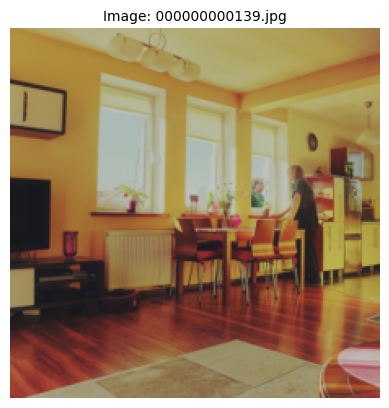

In [12]:
# Choose the image you would like to visualize
img_num = 0 # @param {type:"slider", min:0, max:99, step:1}

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(images[img_num].transpose(1,2,0))
plt.title('Image: ' + images_list[img_num], fontsize=10);

## 2.2 | Generate in silico EEG responses to images

Generating neural responses for images involves two steps. First, you need to choose the training dataset, encoding model type and subject, and load the corresponding EEG encoding model using the `get_encoding_model` method.

If you select encoding models trained on THINGS EEG 2, note that the EEG data used to train and evaluate these encoding models were _z_-scored at each recording session. As a consequence, their generated in silico EEG responses also live in _z_-scored space.

[nsd_man]: https://cvnlab.slite.page/p/X_7BBMgghj/ROIs

In [6]:
# Choose the neural dataset used to train the encoding models
train_dataset = "things_eeg_2" # @param ["things_eeg_2"] {allow-input: true}
print('Train dataset: ' + train_dataset)

# Choose the encoding model type used to generate the in silico neural responses
model = "vit_b_32" # @param ["vit_b_32"] {allow-input: true}
print('Encoding model: ' + model)

# Choose the Subject number for which the encoding model was trained
subject = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"] {type:"raw", allow-input: true}
print('Subject: ' + str(subject))

Train dataset: things_eeg_2
Encoding model: vit_b_32
Subject: 1


In [14]:
"""
Load the encoding model of interest.

Parameters
----------
modality : str
	Neural data modality.
train_dataset : str
	Name of the neural dataset used to train the encoding models.
model : str
	Encoding model type used to generate the in silico neural
	responses.
subject : int
	Subject number for which the encoding model was trained.
roi : str
	Only required if modality=='fmri'. Name of the Region of Interest
	(ROI) for which the fMRI encoding model was trained.
device : str
	Whether the encoding model is stored on the 'cpu' or 'cuda'. If
	'auto', the code will use GPU if available, and otherwise CPU.

Returns
-------
encoding_model : dict
	Neural encoding model.
"""

# Load the EEG encoding model
eeg_encoding_model = ned_object.get_encoding_model(
	modality='eeg',
	train_dataset=train_dataset,
	model=model,
	subject=subject,
	roi=None,
	device='auto'
	)

Next, with the `encode` method you can generate in silico EEG responses to any image of your choice, and optionally return the corresponding metadata.

In [15]:
"""
Generate in silico neural responses for arbitrary stimulus images, and
optionally return the in silico neural responses metadata.

Parameters
----------
encoding_model : list
	Neural encoding model.
images : int
	Images for which the in silico neural responses are generated. Must
	be a 4-D numpy array of shape (Batch size x 3 RGB Channels x Width
	x Height) consisting of integer values in the range [0, 255].
	Furthermore, the images must be of square size (i.e., equal width
	and height).
return_metadata : bool
	If True, return medatata along with the in silico neural responses.
device : str
	Whether to work on the 'cpu' or 'cuda'. If 'auto', the code will
	use GPU if available, and otherwise CPU.

Returns
-------
insilico_neural_responses : float
	In silico neural responses for the input stimulus images.
	If modality=='fmri', the neural response will be of shape:
	(Images x Voxels).
	If modality=='eeg', the neural response will be of shape:
	(Images x Repetitions x Channels x Time points) if
metadata : dict
	In silico neural responses metadata.
"""

# Encode EEG responses to images
insilico_eeg, insilico_eeg_metadata = ned_object.encode(
	eeg_encoding_model,
	images,
	return_metadata=True,
	device='auto'
	)

Encoding EEG responses: 100%|██████████| 1/1 [00:20<00:00, 20.26s/it, Encoded images=100, Total images=100]


The generated in silico EEG responses consist of a 4-D array of shape (Images x Repetitions x Channels x Time points).

In [16]:
# Print the in silico EEG data dimensions
print('In silico EEG data shape:')
print(insilico_eeg.shape)
print('(Images x Repetitions x Channels x Time points)')

In silico EEG data shape:
(100, 4, 63, 140)
(Images x Repetitions x Channels x Time points)


# 3 | In silico EEG responses metadata

The in silico EEG responses optionally come with useful metadata. Note that you can also load the metadata using the `get_metadata` method, without having to generate the in silico EEG responses using the `encode` method.

In [7]:
"""
Get the metadata, consisting in information on the neural data used to
train the encoding models (e.g., the amount of fMRI voxels or EEG time
points), and on the trained encoding models (e.g., how was the data
split to train and test the models, and the models accuracy scores).

Parameters
----------
modality : str
    Neural data modality.
train_dataset : str
    Name of the neural dataset used to train the encoding models.
model : str
    Encoding model type used to generate the in silico neural
    responses.
subject : int
    Subject number for which the metadata is loaded.
roi : str
    Only required if modality=='fmri'. Name of the Region of Interest
    (ROI) for which the metadata is loaded.

Returns
-------
metadata : dict
    In silico neural responses metadata.
"""

# Get the metadata relative to the in silico EEG responses
insilico_eeg_metadata = ned_object.get_metadata(
	modality='eeg',
	train_dataset=train_dataset,
	model=model,
	subject=subject,
	roi=None
	)

The metadata consists of a dictionary with two keys:
* `eeg`: metadata relative to the EEG responses used to train the encoding models.
* `encoding_models`: metadata relative to the trained EEG encoding models.

## 3.1 | EEG metadata

Here you will familiarize with the metadata from the `eeg` key, that is, metadata relative to the EEG responses used to train the encoding models.

### 3.1.1 | EEG channels

The `ch_names` variable is a list of length (Channels), where each list element indicates the name of a given EEG channel.

In [18]:
# Print the EEG channels
print('\nEEG channels:')
for c, chan in enumerate(insilico_eeg_metadata['eeg']['ch_names']):
    print(c, chan)


EEG channels:
0 Fp1
1 F3
2 F7
3 FT9
4 FC5
5 FC1
6 C3
7 T7
8 TP9
9 CP5
10 CP1
11 Pz
12 P3
13 P7
14 O1
15 Oz
16 O2
17 P4
18 P8
19 TP10
20 CP6
21 CP2
22 Cz
23 C4
24 T8
25 FT10
26 FC6
27 FC2
28 F4
29 F8
30 Fp2
31 AF7
32 AF3
33 AFz
34 F1
35 F5
36 FT7
37 FC3
38 FCz
39 C1
40 C5
41 TP7
42 CP3
43 P1
44 P5
45 PO7
46 PO3
47 POz
48 PO4
49 PO8
50 P6
51 P2
52 CPz
53 CP4
54 TP8
55 C6
56 C2
57 FC4
58 FT8
59 F6
60 F2
61 AF4
62 AF8


### 3.1.2 | EEG time points

The `time` variable is a 1-D array of length (Time points), where each vector component indicates the timing of a given EEG time point, in seconds, with respect to stimulus onset.

In [19]:
# Print the EEG time points
print('\nEEG time points (in seconds):')
for t, time in enumerate(insilico_eeg_metadata['eeg']['times']):
    print(t, np.round(time, decimals=3))


EEG time points (in seconds):
0 -0.1
1 -0.095
2 -0.09
3 -0.085
4 -0.08
5 -0.075
6 -0.07
7 -0.065
8 -0.06
9 -0.055
10 -0.05
11 -0.045
12 -0.04
13 -0.035
14 -0.03
15 -0.025
16 -0.02
17 -0.015
18 -0.01
19 -0.005
20 0.0
21 0.005
22 0.01
23 0.015
24 0.02
25 0.025
26 0.03
27 0.035
28 0.04
29 0.045
30 0.05
31 0.055
32 0.06
33 0.065
34 0.07
35 0.075
36 0.08
37 0.085
38 0.09
39 0.095
40 0.1
41 0.105
42 0.11
43 0.115
44 0.12
45 0.125
46 0.13
47 0.135
48 0.14
49 0.145
50 0.15
51 0.155
52 0.16
53 0.165
54 0.17
55 0.175
56 0.18
57 0.185
58 0.19
59 0.195
60 0.2
61 0.205
62 0.21
63 0.215
64 0.22
65 0.225
66 0.23
67 0.235
68 0.24
69 0.245
70 0.25
71 0.255
72 0.26
73 0.265
74 0.27
75 0.275
76 0.28
77 0.285
78 0.29
79 0.295
80 0.3
81 0.305
82 0.31
83 0.315
84 0.32
85 0.325
86 0.33
87 0.335
88 0.34
89 0.345
90 0.35
91 0.355
92 0.36
93 0.365
94 0.37
95 0.375
96 0.38
97 0.385
98 0.39
99 0.395
100 0.4
101 0.405
102 0.41
103 0.415
104 0.42
105 0.425
106 0.43
107 0.435
108 0.44
109 0.445
110 0.45
111 0.455
1

## 3.2 | Encoding models metadata

Now you will familiarize with the metadata from the `encoding_models` key, that is, metadata relative to the trained EEG encoding models.

### 3.2.1 | Encoding models encoding accuracy !!!!!!!!!!!!!!!!!!!

For each THINGS EEG 2 subject, we trained the encoding models using 16,540 images, and tested them on 200 images. We used the trained encoding models to generate the in silico EEG responses for the 200 test images, and compared these in silico EEG responses to the ground truth (real) EEG responses through a Pearson correlation. We correlated ground-truth and in silico EEG responses independently for each EEG channel and time point (across the 200 test images), resulting in one encoding accuracy score for each channel and time point.

Since EEG channels can be grouped based on their position (e.g., occipital, parietal, temporal, central, frontal), here you can choose whether to plot the encoding accuracy for all of the EEG channels, or only for the ones coming from a specific channel group.

In [8]:
# Choose the EEG channels to keep
kept_channels = "occipital" # @param ["occipital", "parietal", "temporal", "central", "frontal", "all"] {allow-input: true}

# Channels selection
if kept_channels != 'all':
	ch_names_kept = []
	idx_ch = []
	for c, chan in enumerate(insilico_eeg_metadata['eeg']['ch_names']):
		if kept_channels[0].upper() in chan:
			ch_names_kept.append(chan)
			idx_ch.append(c)
	idx_ch = np.asarray(idx_ch)
elif kept_channels == 'all':
	ch_names_kept = insilico_eeg_metadata['eeg']['ch_names']
	idx_ch = np.arange(0, len(insilico_eeg_metadata['eeg']['ch_names']))

print('\nKept EEG channels:')
for c, chan in enumerate(ch_names_kept):
    print(c, chan)


Kept EEG channels:
0 O1
1 Oz
2 O2
3 PO7
4 PO3
5 POz
6 PO4
7 PO8


Now you will plot the encoding accuracy averaged across the EEG channels from the chosen channel group, against the (split-half) noise ceiling lower and upper bounds (denoted by the gray region).

Since there are 4 repetitions (i.e., instances) of in silico EEG responses you will plot the correlation score of the ground truth EEG response against each single in silico EEG repetition (black dashed lines), as well as the correlation score of the ground truth EEG response against the average over the 4 in silico EEG repetitions (pink solid line).

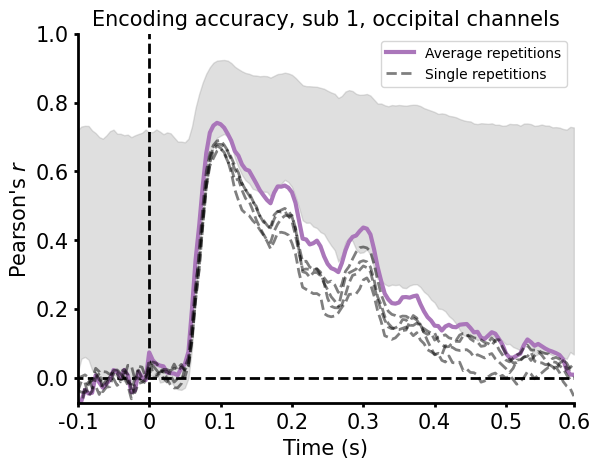

In [9]:
# Get the encoding accuracy results
encoding_acc_all_rep = np.mean(insilico_eeg_metadata['encoding_models']\
    ['encoding_accuracy']['correlation_all_repetitions'][idx_ch], 0)
encoding_acc_single_rep = np.mean(insilico_eeg_metadata['encoding_models']\
    ['encoding_accuracy']['correlation_single_repetitions'][:,idx_ch], 1)
noise_ceiling_low = np.mean(insilico_eeg_metadata['encoding_models']\
    ['encoding_accuracy']['noise_ceiling_lower'][idx_ch], 0)
noise_ceiling_up = np.mean(insilico_eeg_metadata['encoding_models']\
    ['encoding_accuracy']['noise_ceiling_upper'][idx_ch], 0)
times = insilico_eeg_metadata['eeg']['times']

# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
colors = [(170/255, 118/255, 186/255)]
color_noise_ceiling = (150/255, 150/255, 150/255)

# Plot the channel-average encoding accuracy
plt.plot()
plt.plot([-10, 10], [0, 0], 'k--', [0, 0], [100, -100], 'k--', linewidth=2,
    label='_nolegend_')
plt.fill_between(times, noise_ceiling_low, noise_ceiling_up,
    color=color_noise_ceiling, alpha=.3, label='_nolegend_')
plt.plot(times, encoding_acc_all_rep, color=colors[0], linewidth=3,
    label='Average repetitions')
for r, res in enumerate(encoding_acc_single_rep):
    if r == 0:
        plt.plot(times, res, '--', color='k', linewidth=2, alpha=0.5,
            label='Single repetitions')
    else:
        plt.plot(times, res, '--', color='k', linewidth=2, alpha=0.5,
            label='_nolegend_')
plt.ylabel('Pearson\'s $r$', fontsize=fontsize)
plt.ylim(bottom=-.075, top=1)
plt.xlabel('Time (s)', fontsize=fontsize)
xticks = [-0.1, 0, .1, .2, .3, .4, .5, times[-1]]
xlabels = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim(left=min(times), right=max(times));
title = 'Encoding accuracy, sub ' +str(subject) + ', ' + kept_channels + \
    ' channels'
plt.title(title, fontsize=fontsize)
plt.legend(fontsize=fontsize-5);

### 3.2.2 | Encoding models train/val/test split

Finally, here you will plot the image names of the THINGS images used to train (`train_img_files`) and test (`test_img_files`) the encoding model for the chosen subject.

In [22]:
# Training images
train_images = insilico_eeg_metadata\
    ['encoding_models']['train_test_things_image_splits']['train_img_files']
print('Training image number: ' + str(len(train_images)))
print('Training image files:')
print(train_images)

# Test image images
test_images = insilico_eeg_metadata\
    ['encoding_models']['train_test_things_image_splits']['test_img_files']
print('\n\nTest image number: ' + str(len(test_images)))
print('Test image files:')
print(test_images)

Training image number: 16540
Training image files:
['aardvark_01b.jpg', 'aardvark_02s.jpg', 'aardvark_03s.jpg', 'aardvark_04s.jpg', 'aardvark_05s.jpg', 'aardvark_06s.jpg', 'aardvark_07s.jpg', 'aardvark_08s.jpg', 'aardvark_09s.jpg', 'aardvark_10s.jpg', 'abacus_01b.jpg', 'abacus_02s.jpg', 'abacus_03s.jpg', 'abacus_04s.jpg', 'abacus_05s.jpg', 'abacus_06s.jpg', 'abacus_07s.jpg', 'abacus_08s.jpg', 'abacus_09s.jpg', 'abacus_10s.jpg', 'accordion_01b.jpg', 'accordion_02s.jpg', 'accordion_03s.jpg', 'accordion_04s.jpg', 'accordion_05s.jpg', 'accordion_06s.jpg', 'accordion_07s.jpg', 'accordion_08s.jpg', 'accordion_09s.jpg', 'accordion_10s.jpg', 'acorn_01b.jpg', 'acorn_02n.jpg', 'acorn_03s.jpg', 'acorn_04s.jpg', 'acorn_05s.jpg', 'acorn_06s.jpg', 'acorn_07s.jpg', 'acorn_08s.jpg', 'acorn_09s.jpg', 'acorn_10s.jpg', 'air_conditioner_01b.jpg', 'air_conditioner_02s.jpg', 'air_conditioner_03s.jpg', 'air_conditioner_04s.jpg', 'air_conditioner_05s.jpg', 'air_conditioner_06s.jpg', 'air_conditioner_07s.jpg',

# 4 | Load and visualize the pre-generated in silico EEG responses

The Neural Encoding Dataset comes with pre-generated in silico fMRI and EEG responses for ~150,000 naturalistic images from the [ImageNet 2012 Challenge][imagenet] ([*Russakovsky et al., 2015*][russakovsky]), the [THINGS Database][things] ([*Hebart et al., 2019*][hebart]), and the [Natural Scenes Dataset][nsd] ([*Allen et al., 2022*][allen]), which you can use for research purposes. Here you will load and visualize these in silico EEG responses.

[nsd]: https://naturalscenesdataset.org/
[allen]: https://doi.org/10.1038/s41593-021-00962-x
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://doi.org/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://doi.org/10.1371/journal.pone.0223792

## 4.1 | Data selection

We provide pre-generated in silico EEG responses for the following attribute conmbinations:
* `train_dataset == 'things_eeg_2'`
* `model == 'vit_b_32'`

Here you can choose the subject and imageset for which you will load the pre-generated in silico EEG responses.

If you select encoding models trained on THINGS EEG 2, note that the EEG data used to train and evaluate these encoding models were _z_-scored at each recording session. As a consequence, their generated in silico EEG responses also live in _z_-scored space.

In [23]:
# Used subject
subject = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"] {type:"raw", allow-input: true}
print('Subject: ' + str(subject))

# Used image set
imageset = "nsd" # @param ["nsd", "imagenet_val", "things"] {allow-input: true}
print('Imageset: ' + imageset)

Subject: 1
Imageset: nsd


## 4.2 | Load the in silico EEG responses

Now you will load the in silico EEG responses for the chosen subject and image set, using the `load_insilico_neural_responses` method.

The in silico EEG responses consist of a 4-D array of shape (Images x Repetitions x Channels x Time points).

In [24]:
"""
Load NED's pre-generated in silico neural responses, and optionally
their metadata.

Parameters
----------
modality : str
    Neural data modality.
train_dataset : str
    Name of the neural dataset used to train the encoding models.
model : str
    Encoding model type used to generate the in silico neural
    responses.
imageset : str
    Imageset for which the in silico neural responses are generated.
    Available options are 'nsd', 'imagenet_val' and 'things'.
    If 'nsd', load in silico neural responses for the 73,000 NSD images
    (Allen et al., 2023).
    If 'imagenet_val', load in silico neural responses for the 50,000
    ILSVRC-2012 validation images (Russakovsky et al., 2015).
    If 'things', load in silico neural responses for the 26,107 images
    from the THINGS database (Hebart et al., 2019).
subject : int
    Subject number for which the in silico neural image responses are
    generated.
roi : str
    Only required if modality=='fmri'. Name of the Region of Interest
    (ROI) for which the in silico fMRI responses are generated.
return_metadata : bool
    If True, additionally return in silico neural responses metadata.

Returns
-------
insilico_neural_responses : h5py
    In silico neural responses for the input stimulus images.
    If modality=='fmri', the neural response will be of shape:
    (Images x Voxels).
    If modality=='eeg', the neural response will be of shape:
    (Images x Repetitions x Channels x Time points) if
metadata : dict
    In silico neural responses metadata.
"""

# Load the pre-generated in silico EEG responses
insilico_eeg, insilico_eeg_metadata = ned_object.load_insilico_neural_responses(
	modality='eeg',
	train_dataset='things_eeg_2',
	model='vit_b_32',
	imageset=imageset,
	subject=subject,
	roi=None,
	return_metadata=True
	)

# Print the in silico EEG data dimensions
print('In silico EEG data shape:')
print(insilico_eeg.shape)
print('(Images x Repetitions x Channels x Time points)')

In silico EEG data shape:
(73000, 4, 63, 140)
(Images x Repetitions x Channels x Time points)


The `load_insilico_neural_responses` method optionally returns metadata for the pre-generated in silico EEG responses.

This metadata is identical to the metadata loaded with the `get_metadata` method in section `3 | In silico EEG responses metadata`, with the addition of information relative to the image sets used to generate the in silico EEG responses. You will use this additional image-set-related metadata in the next section.

## 4.3 | Link the in silico EEG responses to the corresponding images

Here you will match the pre-generated in silico EEG responses to the corresponding images. You will start by accessing the imagesets. Since the NSD, ILSVRC-2012, and THINGS imagesets are organized differently, you will access each of them in a different way.

<font color='red'><b>NOTE:</b></font> **Prior to using the NSD images you are required to fill out the [NSD Data Access Agreement][nsd_access].**

[nsd_access]: https://forms.gle/eT4jHxaWwYUDEf2i9

In [25]:
# Access the imagesets
if imageset == 'nsd':
    imageset_dir = os.path.join(ned_dir,
        'pregenerated_insilico_neural_responses', 'imagesets', 'imageset-nsd',
        'nsd_stimuli.hdf5')
    images = h5py.File(imageset_dir, 'r')
    images = images.get('imgBrick')
elif imageset == 'imagenet_val':
    imageset_dir = os.path.join(ned_dir,
        'pregenerated_insilico_neural_responses', 'imagesets',
        'imageset-imagenet_val')
    images = torchvision.datasets.ImageNet(root=imageset_dir, split='val')
elif imageset == 'things':
    images = insilico_eeg_metadata['things_labels']['image_paths']

Here you can choose an image (indexing is zero-based), and link it to the corresponding in silico EEG response.

In [26]:
# Choose the image
if imageset == 'nsd':
    nsd_img = 0 # @param {type:"slider", min:0, max:72999, step:1}
    img_idx = nsd_img
elif imageset == 'imagenet_val':
    imagenet_img = 0 # @param {type:"slider", min:0, max:49999, step:1}
    img_idx = imagenet_img
elif imageset == 'things':
    things_img = 0 # @param {type:"slider", min:0, max:26106, step:1}
    img_idx = things_img

# Link the image to the corresponding in silico EEG response
eeg_response = insilico_eeg[img_idx]
print('In silico EEG response shape:')
print(eeg_response.shape)
print('(Repetitions x Channels x Time points)')

In silico EEG response shape:
(4, 63, 140)
(Repetitions x Channels x Time points)


And now you will load and visualize the image you chose, along with optional metadata (e.g., image category).

Since the ILSVRC-2012 images are rectangular, we center cropped them to square format prior to feeding them to encoding models to generate their corresponding in silico EEG responses. Here you will apply the same center cropping when loading these images. The NSD and THINGS images are already in square format, and therefore don't require any cropping.

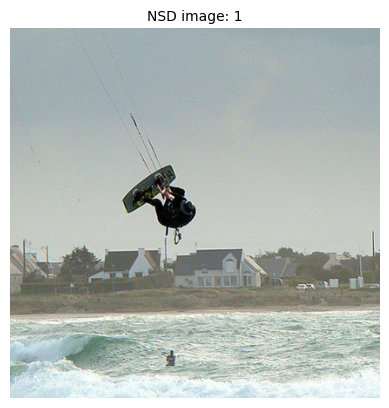

In [27]:
# Load the selected image
if imageset == 'nsd':
    img = images[img_idx]
elif imageset == 'imagenet_val':
    img, _ = images.__getitem__(img_idx)
    transform = trn.Compose([trn.CenterCrop(min(img.size))])
    img = transform(img)
elif imageset == 'things':
    img_dir = os.path.join(ned_dir, 'pregenerated_insilico_neural_responses',
        'imagesets', 'imageset-things', 'images', images[img_idx])
    img = Image.open(img_dir).convert('RGB')

# Visualize the image (along with otptional metadata)
plt.figure()
plt.axis('off')
plt.imshow(img)
if imageset == 'nsd':
    title = 'NSD image: ' + str(img_idx+1)
elif imageset == 'imagenet_val':
    label_number = insilico_eeg_metadata['imagenet_val_labels']['label_number']\
        [img_idx]
    label_name = insilico_eeg_metadata['imagenet_val_labels']['label_names']\
        [label_number]
    title = 'ILSVRC-2012 validation image: ' + str(img_idx+1) + \
        '\nCategory number: ' + str(label_number+1) + \
        '\nCategory name: ' + label_name
elif imageset == 'things':
    object_concept_number = \
        insilico_eeg_metadata['things_labels']['image_concept_index'][img_idx]
    object_concept_name = insilico_eeg_metadata['things_labels']['unique_id']\
        [object_concept_number]
    file_name = insilico_eeg_metadata['things_labels']['image_paths'][img_idx]
    title = 'THINGS image: ' + str(img_idx+1) + \
        '\nObject concept number: ' + str(object_concept_number+1) + \
        '\nObject concept name: ' + object_concept_name + \
        '\nFile name: ' + file_name
plt.title(title, fontsize=10);

## 4.4 | Pairwise decoding

Here you will quantitatively evaluate the visual information present in the in silico EEG responses through pairwise decoding. Pairwise decoding is a commonly used method in computational neuroscience which exploits similar information present across several response repetitions for the same stimulus condition to classify the stimulus conditions of these neural responses ([Haynes and Rees, 2006][haynes]; [Mur et al., 2009][mur]).

[haynes]: https://doi.org/10.1038/nrn1931
[mur]: https://doi.org/10.1093/scan/nsn044

Since EEG channels can be grouped based on their position (e.g., occipital, parietal, temporal, central, frontal), here you can choose whether to perform pairwise decodng using all the EEG channels, or only the ones coming from a specific channel group.

In [28]:
# Choose the EEG channels to keep
kept_channels = "occipital" # @param ["occipital", "parietal", "temporal", "central", "frontal", "all"] {allow-input: true}

# Channels selection
if kept_channels != 'all':
	ch_names_kept = []
	idx_ch = []
	for c, chan in enumerate(insilico_eeg_metadata['eeg']['ch_names']):
		if kept_channels[0].upper() in chan:
			ch_names_kept.append(chan)
			idx_ch.append(c)
	idx_ch = np.asarray(idx_ch)
elif kept_channels == 'all':
	ch_names_kept = insilico_eeg_metadata['eeg']['ch_names']
	idx_ch = np.arange(0, len(insilico_eeg_metadata['eeg']['ch_names']))

print('\nKept EEG channels:')
for c, chan in enumerate(ch_names_kept):
    print(c, chan)


Kept EEG channels:
0 O1
1 Oz
2 O2
3 PO7
4 PO3
5 POz
6 PO4
7 PO8


To reduce computational load, you will now select the 50 image conditions you will use for the pairwise decoding, through the following selection scheme:
* **NSD in silico EEG response:** the first 50 images from the 1000 NSD shared images (the 1000 images seen by all NSD subjects).
* **ImageNet in silico EEG response:** 50 images, each coming from one of the 1000 object categories.
* **THINGS in silico EEG response:** the first 50 test image conditions from the THINGS EEG 2 dataset.

In [29]:
# Select the NSD image conditions
if imageset == 'nsd':
    img_idx = insilico_eeg_metadata['nsd_labels']['subjectim'][0,:50]

# Select the ImageNet image conditions
elif imageset == 'imagenet_val':
    img_idx = np.arange(0, 50000, 50)[:50]

# Select the THINGS image conditions
elif imageset == 'things':
    image_paths = insilico_eeg_metadata['things_labels']['image_paths']
    image_metadata = insilico_eeg_metadata['encoding_models']\
        ['train_test_things_image_splits']
    img_idx = []
    idx = 0
    for i, path in enumerate(image_paths.values()):
        if len(img_idx) < len(image_metadata['test_img_concepts']):
            fname = image_metadata['test_img_concepts'][idx][6:] + '/' + \
                image_metadata['test_img_files'][idx]
            if path == fname:
                img_idx.append(i)
                idx += 1
    img_idx = np.asarray(img_idx)[:50]

# Read the EEG data into memory
decoding_data = insilico_eeg[img_idx,:]
decoding_data = decoding_data[:,:,idx_ch]

# Print the selected in silico EEG data dimensions
print('In silico EEG data shape:')
print(decoding_data.shape)
print('(Images x Repetitions x Channels x Time points)')

In silico EEG data shape:
(50, 4, 8, 140)
(Images x Repetitions x Channels x Time points)


Now you will perform pairwise decoding on the in silico EEG responses for the selected images. You will train linear support vector machines (SVMs) to perform binary classification between the EEG reeponses for each pair of image conditions using 3 out of 4 repeats, and then test the trained SVMs on the left out repeat (until every repeat is left out once). The analysis is performed independently for each EEG time point, where at each time point the SVMs are trained using the responses of the different EEG channels.

In [30]:
# Results array of shape:
# (Image conditions x Image conditions x EEG times)
pairwise_decoding = np.zeros((len(decoding_data), len(decoding_data),
    len(times)))

# Loop over EEG time, image conditions and EEG repetitions
for t in tqdm(range(len(times))):
    for i1 in range(len(decoding_data)):
        for i2 in range(i1):
            # Select the image condition data
            eeg_cond_1 = decoding_data[i1,:,:,t]
            eeg_cond_2 = decoding_data[i2,:,:,t]
            # SVM target vectors
            y_train = np.zeros(((len(eeg_cond_1)-1)*2))
            y_train[int(len(y_train)/2):] = 1
            y_test = np.asarray((0, 1))
            scores = np.zeros(len(eeg_cond_1))
            for r in range(len(eeg_cond_1)):
                # Define the training/test partitions
                X_train = np.append(np.delete(eeg_cond_1, r, 0),
                    np.delete(eeg_cond_2, r, 0), 0)
                X_test = np.append(np.expand_dims(eeg_cond_1[r], 0),
                    np.expand_dims(eeg_cond_2[r], 0), 0)
                # Train the classifier
                dec_svm = SVC(kernel='linear')
                dec_svm.fit(X_train, y_train)
                # Test the classifier
                y_pred = dec_svm.predict(X_test)
                scores[r] = sum(y_pred == y_test) / len(y_test)
            # Store the accuracy
            pairwise_decoding[i1,i2,t] = np.mean(scores)
            pairwise_decoding[i2,i1,t] = pairwise_decoding[i1,i2,t]

100%|██████████| 140/140 [15:10<00:00,  6.50s/it]


For each EEG time point, pairwise decoding results in a symmetric 2-D results array of shape (Images × Images), where each array entry indicates how well the EEG responses for two image conditions can be decoded (i.e, differentiated). Since this is a binary choice, chance level consists in a decoding accuracy of 50%.

The more dissimilar the EEG responses for two stimulus conditions are, the better these conditions can be decoded. Thus, the symmetric 2-D results arrays are also referred to as a representational dissimilarity matrices (RDMs).

Here you will plot the RDMs for three EEG time points (with respect to stimulus onset): 0 seconds, 0.1 seconds, 0.2 seconds. Notice how the decoding accuracies for the 0 seconds RDM are at chance level, since it takes ~60 milliseconds for the stimulus visual information from the presentation screen to reach visual cortex.

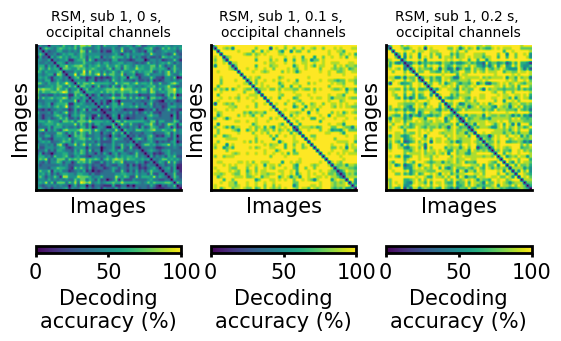

In [31]:
# Get the EEG time points
times = np.round(insilico_eeg_metadata['eeg']['times'], decimals=3)
plot_times = [0, 0.1, 0.2]

# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3

# Initialize the figure
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs = np.reshape(axs, (-1))

# Plot the pairwise decoding RSMs
for t in range(len(axs)):
    # Select the time point of interest
    idx_time = np.where(times == plot_times[t])[0][0]
    # Plot the RSMs
    img = axs[t].imshow(pairwise_decoding[:,:,idx_time]*100, aspect='equal')
    plt.colorbar(img, label='Decoding\naccuracy (%)', fraction=0.025, ax=axs[t],
        orientation='horizontal')
    # Plot parameters
    axs[t].set_xlabel('Images', fontsize=fontsize)
    axs[t].set_ylabel('Images', fontsize=fontsize)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    title = 'RSM, ' + str(plot_times[t])
    title = 'RSM, sub ' +str(subject) + ', ' + str(plot_times[t]) + ' s, \n' + \
        kept_channels + ' channels'
    axs[t].set_title(title, fontsize=10)

Finally, you will now average the lower triangular RDM entries at each time points, and plot the resulting temporal course of EEG decoding accurary.

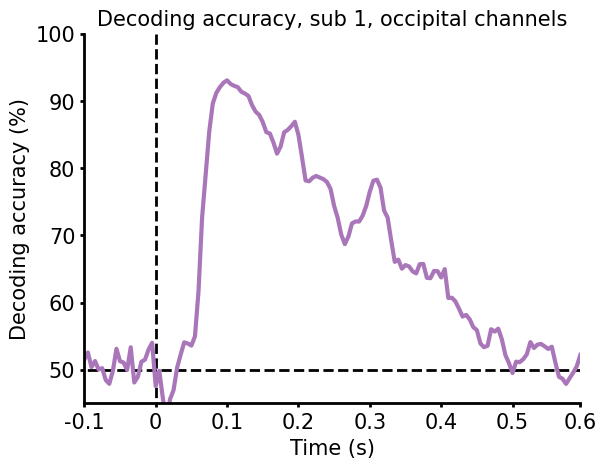

In [32]:
# Average the decoding accuracies across pairwise comparisons
idx_tril = np.tril_indices(len(decoding_data), -1)
decoding_mean = np.mean(pairwise_decoding[idx_tril], 0) * 100

# Plot the pairwise decoding results
plt.plot()
plt.plot([-10, 10], [50, 50], 'k--', [0, 0], [100, -100], 'k--', linewidth=2)
plt.plot(times, decoding_mean, color=colors[0], linewidth=3)
plt.ylabel('Decoding accuracy (%)', fontsize=fontsize)
plt.ylim(bottom=45, top=100)
plt.xlabel('Time (s)', fontsize=fontsize)
xticks = [-0.1, 0, .1, .2, .3, .4, .5, times[-1]]
xlabels = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim(left=min(times), right=max(times));
title = 'Decoding accuracy, sub ' +str(subject) + ', ' + kept_channels + \
    ' channels'
plt.title(title, fontsize=fontsize);